# Kaggle Titanic Project

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [184]:
test = pd.read_csv('C:/Users/Michael/Documents/Data Science Projects/Titanic/test.csv')
train = pd.read_csv('C:/Users/Michael/Documents/Data Science Projects/Titanic/train.csv')
gender_submission = pd.read_csv('C:/Users/Michael/Documents/Data Science Projects/Titanic/gender_submission.csv') 

In [140]:
test.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


## Exploration

In [141]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 83.6+ KB


In [142]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
PassengerId    418 non-null int64
Pclass         418 non-null int64
Name           418 non-null object
Sex            418 non-null object
Age            332 non-null float64
SibSp          418 non-null int64
Parch          418 non-null int64
Ticket         418 non-null object
Fare           417 non-null float64
Cabin          91 non-null object
Embarked       418 non-null object
dtypes: float64(2), int64(4), object(5)
memory usage: 36.0+ KB


In [143]:
gender_submission.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 2 columns):
PassengerId    418 non-null int64
Survived       418 non-null int64
dtypes: int64(2)
memory usage: 6.6 KB


Goal will be to create a classifier based on sex, Pclass, and age

In [144]:
train[train.Pclass.isnull()]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked


In [145]:
train[train.Sex.isnull()]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked


In [146]:
len(train[train.Age.isnull()])

177

Check if this includes passengers who did not embark

In [147]:
pd.unique(train.Embarked)

array(['S', 'C', 'Q', nan], dtype=object)

This field is actually the location where the embarked. However, there are a few NaN values

Remove passengers that we don't know if they embarked or not

### Explore categories / features

In [148]:
train.groupby('Survived')['Name'].count()

Survived
0    549
1    342
Name: Name, dtype: int64

In [149]:
train.groupby('Pclass')['Survived'].mean()

Pclass
1    0.629630
2    0.472826
3    0.242363
Name: Survived, dtype: float64

In [150]:
train.groupby('Sex')['Survived'].mean()

Sex
female    0.742038
male      0.188908
Name: Survived, dtype: float64

In [151]:
train.groupby(['Pclass', 'Sex'])['Survived'].mean().unstack('Sex')

Sex,female,male
Pclass,,
1,0.968085,0.368852
2,0.921053,0.157407
3,0.500000,0.135447


In [152]:
train.groupby(['Pclass', 'Sex'])['Survived'].count().unstack('Sex')

Sex,female,male
Pclass,,
1,94,122
2,76,108
3,144,347


Get values of SibSp

In [16]:
pd.unique(train.SibSp)

array([1, 0, 3, 4, 2, 5, 8], dtype=int64)

In [17]:
pd.unique(train.Parch)

array([0, 1, 2, 5, 3, 4, 6], dtype=int64)

In [18]:
train.groupby('Parch').agg({'Survived' : ['mean', 'count']})

Survived      
           mean count
Parch                
0      0.343658   678
1      0.550847   118
2      0.500000    80
3      0.600000     5
4      0.000000     4
5      0.200000     5
6      0.000000     1

In [19]:
test.groupby('Parch').agg({'PassengerId' : ['count']})

,PassengerId
,count
Parch,
0,324
1,52
2,33
3,3
4,2
5,1
6,1
9,2


### Explore methods of imputing ages

In [21]:
train['Salutation'] = train.Name.str.extract('([A-Za-z]+)\.')

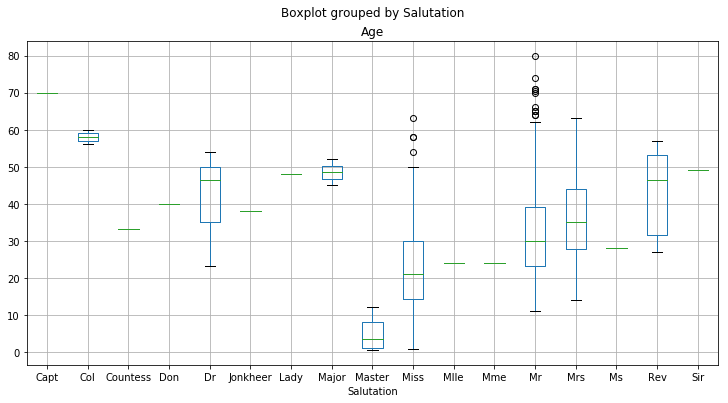

In [22]:
plt.rcParams['figure.figsize'] = [12,6]
train.boxplot(column=['Age'], by='Salutation')

In [23]:
train['Initial'] = train['Salutation']
train['Initial'].replace(['Mr', 'Mrs', 'Miss', 'Master', 'Don', 'Rev', 'Dr', 'Mme', 'Ms', 'Major', 'Lady', 'Sir', 'Mlle', 'Col', 'Capt', 'Countess', 'Jonkheer'],
['Mr', 'Mrs', 'Miss', 'Master', 'Mr', 'Other', 'Mr', 'Miss', 'Miss', 'Mr', 'Mrs', 'Mr', 'Miss', 'Other', 'Mr', 'Mrs', 'Other'], inplace= True)

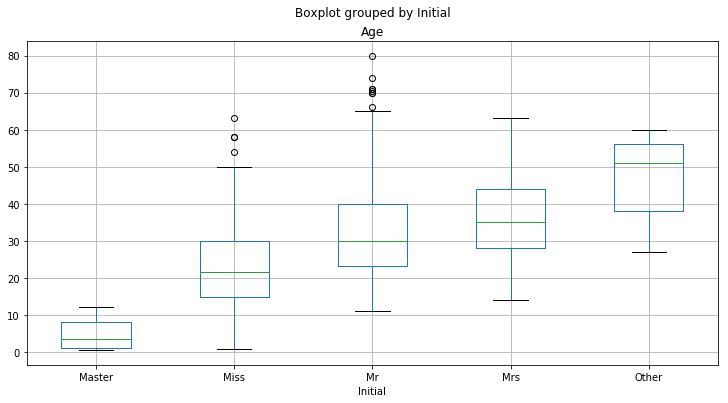

In [24]:
plt.rcParams['figure.figsize'] = [12,6]
train.boxplot(column=['Age'], by='Initial')

In [25]:
age_fills = train.groupby('Initial')['Age'].mean().apply(lambda x: round(x))

In [26]:
for salutation, age in age_fills.iteritems():
    train.loc[(train.Initial==salutation) & (train.Age.isnull()),'Age'] = age

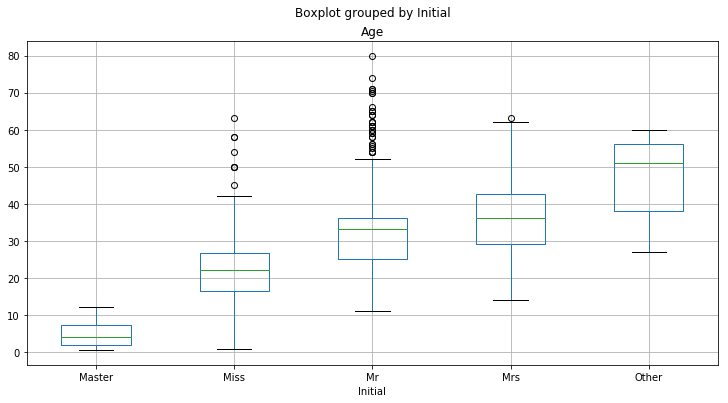

In [27]:
plt.rcParams['figure.figsize'] = [12,6]
train.boxplot(column=['Age'], by='Initial')

## Machine Learning Pipeline Start

### Pre-Process Data

In [158]:
def Pre_Process_Pipeline(df, option, max_Age=0):    
    # Convert male / female to 1/0
    from sklearn.preprocessing import LabelEncoder

    sex_le = LabelEncoder()
    sex_le.fit(df['Sex'])
    df['Sex'] = sex_le.transform(df['Sex'])
    
    # One Hot encoder of Pclass
    pclass_df = pd.get_dummies(df['Pclass'], prefix='Pclass')
    df = pd.concat([df, pclass_df], axis=1)
    
    # Create Binary Has SibSp and HasParch
    df['HasSibSp'] = df['SibSp'].apply(lambda x: 1 if x>0 else 0)    
    df['HasParch'] = df['Parch'].apply(lambda x: 1 if x>0 else 0)
    
    # Impute missing age values
    df['Salutation'] = df.Name.str.extract('([A-Za-z]+)\.')
    df['Initial'] = df['Salutation']
    df['Initial'].replace(['Mr', 'Mrs', 'Miss', 'Master', 'Don', 'Rev', 'Dr', 'Mme', 'Ms', 'Major', 'Lady', 'Sir', 'Mlle', 'Col', 'Capt', 'Countess', 'Jonkheer'],
                                ['Mr', 'Mrs', 'Miss', 'Master', 'Mr', 'Other', 'Mr', 'Miss', 'Miss', 'Mr', 'Mrs', 'Mr', 'Miss', 'Other', 'Mr', 'Mrs', 'Other'], 
                                  inplace= True)
    age_fills = df.groupby('Initial')['Age'].mean().apply(lambda x: round(x))
    for salutation, age in age_fills.iteritems():
        df.loc[(df.Initial==salutation) & (df.Age.isnull()),'Age'] = age
        
    # Normalize Age
    if option == 'train':
        max_Age = max(df['Age'])
    df['Age'] = df['Age']/max_Age  
    
    return df, max_Age

In [198]:
train, max_Age = Pre_Process_Pipeline(train, 'train')

In [199]:
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Pclass_1,Pclass_2,Pclass_3,HasSibSp,HasParch,Salutation,Initial
0,1,0,3,"Braund, Mr. Owen Harris",1,0.2750,1,0,A/5 21171,7.2500,NaN,S,0,0,1,1,0,Mr,Mr
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",0,0.4750,1,0,PC 17599,71.2833,C85,C,1,0,0,1,0,Mrs,Mrs
2,3,1,3,"Heikkinen, Miss. Laina",0,0.3250,0,0,STON/O2. 3101282,7.9250,NaN,S,0,0,1,0,0,Miss,Miss
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",0,0.4375,1,0,113803,53.1000,C123,S,1,0,0,1,0,Mrs,Mrs
4,5,0,3,"Allen, Mr. William Henry",1,0.4375,0,0,373450,8.0500,NaN,S,0,0,1,0,0,Mr,Mr


In [161]:
X_train = train[['Sex', 'Pclass_1', 'Pclass_2', 'Pclass_3', 'Age', 'HasSibSp', 'HasParch']]
y_train = train['Survived']

## Test Models

### Neural Network

In [162]:
from sklearn.neural_network import MLPClassifier

In [163]:
mlp = MLPClassifier(hidden_layer_sizes = (5,), solver='lbfgs', max_iter = 200)

In [164]:
mlp.fit(X_train, y_train)

MLPClassifier(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(5,), learning_rate='constant',
       learning_rate_init=0.001, max_iter=200, momentum=0.9,
       n_iter_no_change=10, nesterovs_momentum=True, power_t=0.5,
       random_state=None, shuffle=True, solver='lbfgs', tol=0.0001,
       validation_fraction=0.1, verbose=False, warm_start=False)

In [165]:
y_pred = mlp.predict(X_train)

In [166]:
np.asarray(X_train)

array([[1.   , 0.   , 0.   , ..., 0.275, 1.   , 0.   ],
       [0.   , 1.   , 0.   , ..., 0.475, 1.   , 0.   ],
       [0.   , 0.   , 0.   , ..., 0.325, 0.   , 0.   ],
       ...,
       [0.   , 0.   , 0.   , ..., 0.275, 1.   , 1.   ],
       [1.   , 1.   , 0.   , ..., 0.325, 0.   , 0.   ],
       [1.   , 0.   , 0.   , ..., 0.4  , 0.   , 0.   ]])

In [167]:
1-sum((y_pred - y_train)**2)/len(y_train)

0.813692480359147

### Plot Learning Curve

In [168]:
from sklearn.model_selection import learning_curve

In [169]:
def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None):
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    return plt

(0.5, 1)

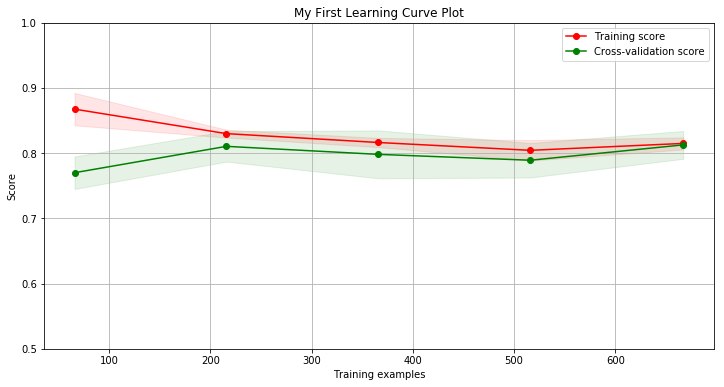

In [170]:
plot_learning_curve(
    MLPClassifier(hidden_layer_sizes = (5,), solver='lbfgs', max_iter = 200),
    'My First Learning Curve Plot',
    X_train, y_train, cv = 4)
plt.ylim([0.5, 1])

### Try Decision Tree

In [171]:
from sklearn.tree import DecisionTreeClassifier

In [172]:
X_train = train[['Sex', 'Pclass_1', 'Pclass_2', 'Pclass_3', 'Age', 'SibSp', 'Parch']]
y_train = train['Survived']

In [173]:
dt_clf = DecisionTreeClassifier()

In [174]:
dt_clf.fit(X_train, y_train)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

In [175]:
dt_clf.score(X_train, y_train)

0.920314253647587

In [176]:
dt_clf.decision_path(X_train)[1]

<1x361 sparse matrix of type '<class 'numpy.int64'>'
	with 7 stored elements in Compressed Sparse Row format>

In [177]:
from sklearn.model_selection import cross_val_score

In [178]:
cross_val_score(dt_clf, X_train, y_train, cv=4).mean()

0.7969161205568157

(0.5, 1)

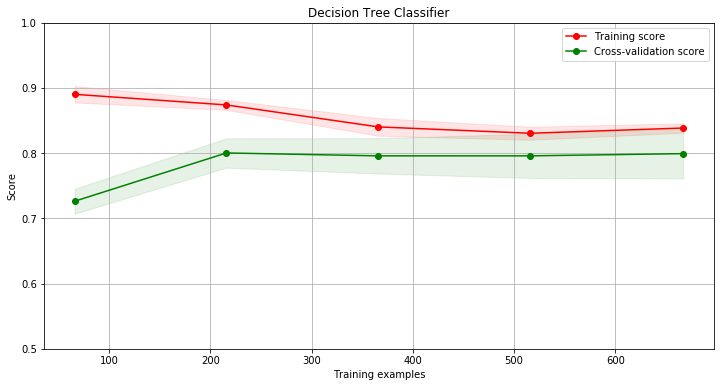

In [179]:
plot_learning_curve(
    DecisionTreeClassifier(max_depth=4),
    'Decision Tree Classifier',
    X_train, y_train, cv = 4)
plt.ylim([0.5, 1])

## Test Models

In [185]:
test, max_Age = Pre_Process_Pipeline(test, 'test', max_Age)

In [187]:
X_test = test[['Sex', 'Pclass_1', 'Pclass_2', 'Pclass_3', 'Age', 'HasSibSp', 'HasParch']]

In [188]:
X_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 7 columns):
Sex         418 non-null int32
Pclass_1    418 non-null uint8
Pclass_2    418 non-null uint8
Pclass_3    418 non-null uint8
Age         418 non-null float64
HasSibSp    418 non-null int64
HasParch    418 non-null int64
dtypes: float64(1), int32(1), int64(2), uint8(3)
memory usage: 12.7 KB


In [189]:
y_test_pred = mlp.predict(X_test)

In [210]:
test.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Pclass_1,Pclass_2,Pclass_3,HasSibSp,HasParch,Salutation,Initial
0,892,3,"Kelly, Mr. James",1,0.43125,0,0,330911,7.8292,NaN,Q,0,0,1,0,0,Mr,Mr
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",0,0.58750,1,0,363272,7.0000,NaN,S,0,0,1,1,0,Mrs,Mrs
2,894,2,"Myles, Mr. Thomas Francis",1,0.77500,0,0,240276,9.6875,NaN,Q,0,1,0,0,0,Mr,Mr
3,895,3,"Wirz, Mr. Albert",1,0.33750,0,0,315154,8.6625,NaN,S,0,0,1,0,0,Mr,Mr
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",0,0.27500,1,1,3101298,12.2875,NaN,S,0,0,1,1,1,Mrs,Mrs


In [211]:
passengerId = test.PassengerId
prediction = pd.Series(y_test_pred, name='Survived')
submission = pd.DataFrame({'PassengerId': passengerId, 'Survived': prediction})

In [ ]:
submission.to_csv('C:/Users/Michael/Documents/Data Science Projects/Titanic/submission.csv')

### Calculate Accuracy

In [190]:
mlp.score(X_test, gender_submission.Survived)

0.9282296650717703

In [192]:
((y_test_pred - np.asarray(gender_submission.Survived))==0).mean()

0.9282296650717703

In [194]:
from sklearn.metrics import f1_score

In [195]:
f1_score(gender_submission.Survived, y_test_pred)

0.895104895104895

In [196]:
from sklearn.metrics import confusion_matrix

In [197]:
confusion_matrix(gender_submission.Survived, y_test_pred)

array([[260,   6],
       [ 24, 128]], dtype=int64)

### Perform Error Analysis on Decision Tree
Will look at which groups have the worst accuracy

In [50]:
from sklearn.model_selection import cross_val_predict

In [98]:
y_pred = cross_val_predict(dt_clf, X_train, y_train, cv=4)
y_pred = pd.Series(data=y_pred, index=X_train.index, name='Predicted')

In [102]:
cross_val = pd.concat([X_train, y_train, y_pred], axis=1)

In [104]:
cross_val.head()

,Sex,Pclass_1,Pclass_2,Pclass_3,Age,Survived,Predicted
0,1,0,0,1,0.2750,0,0
1,0,1,0,0,0.4750,1,1
2,0,0,0,1,0.3250,1,0
3,0,1,0,0,0.4375,1,1
4,1,0,0,1,0.4375,0,0


In [105]:
cross_val['Age'] = cross_val['Age']*max_Age
cross_val['Sex'] = sex_le.inverse_transform(cross_val['Sex'])

In [109]:
cross_val['Pclass'] = cross_val[['Pclass_1', 'Pclass_2', 'Pclass_3']].idxmax(axis=1)

In [112]:
cross_val['Correct'] = cross_val['Survived'] == cross_val['Predicted']

In [113]:
cross_val.head()

,Sex,Pclass_1,Pclass_2,Pclass_3,Age,Survived,Predicted,Pclass,Correct
0,male,0,0,1,22.0,0,0,Pclass_3,True
1,female,1,0,0,38.0,1,1,Pclass_1,True
2,female,0,0,1,26.0,1,0,Pclass_3,False
3,female,1,0,0,35.0,1,1,Pclass_1,True
4,male,0,0,1,35.0,0,0,Pclass_3,True


In [119]:
cross_val.groupby(['Sex', 'Pclass']).agg({'Correct':['mean', 'count']}).unstack('Sex')

Correct                      
              mean            count     
Sex         female      male female male
Pclass                                  
Pclass_1  0.929412  0.663366     85  101
Pclass_2  0.878378  0.929293     74   99
Pclass_3  0.666667  0.837945    102  253

In [120]:
cross_val.groupby(['Sex', 'Pclass']).agg({'Survived':['mean', 'count']}).unstack('Sex')

Survived                      
              mean            count     
Sex         female      male female male
Pclass                                  
Pclass_1  0.964706  0.396040     85  101
Pclass_2  0.918919  0.151515     74   99
Pclass_3  0.460784  0.150198    102  253

In [121]:
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Pclass_1,Pclass_2,Pclass_3
0,1,0,3,"Braund, Mr. Owen Harris",1,0.2750,1,0,A/5 21171,7.2500,NaN,S,0,0,1
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",0,0.4750,1,0,PC 17599,71.2833,C85,C,1,0,0
2,3,1,3,"Heikkinen, Miss. Laina",0,0.3250,0,0,STON/O2. 3101282,7.9250,NaN,S,0,0,1
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",0,0.4375,1,0,113803,53.1000,C123,S,1,0,0
4,5,0,3,"Allen, Mr. William Henry",1,0.4375,0,0,373450,8.0500,NaN,S,0,0,1


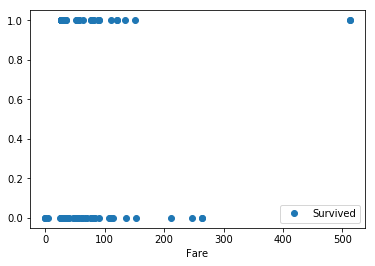

In [138]:
train[(train.Sex==1) & (train.Pclass==1)].plot(x='Fare', y='Survived', marker='o', linewidth=0)

In [142]:
train[(train.Sex==1) & (train.Pclass==1)].groupby(['SibSp', 'Parch']).agg({'Survived':['mean', 'count']}).unstack('SibSp')

Survived                                          
           mean                     count                
SibSp         0         1    2    3     0     1    2    3
Parch                                                    
0      0.370370  0.454545  0.5  NaN  54.0  22.0  2.0  NaN
1      0.222222  0.400000  NaN  NaN   9.0   5.0  NaN  NaN
2      0.500000  1.000000  NaN  0.0   4.0   3.0  NaN  1.0
4           NaN  0.000000  NaN  NaN   NaN   1.0  NaN  NaN

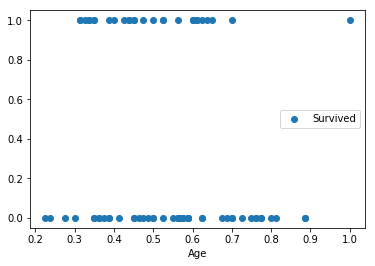

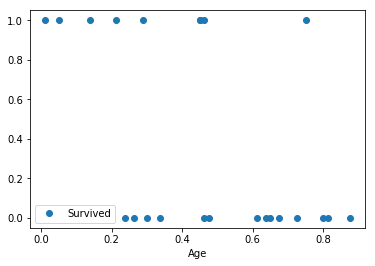

In [146]:
train[(train.Sex==1) & (train.Pclass==1) & (train.Parch==0)].plot(x='Age', y='Survived', marker='o', linewidth=0)
train[(train.Sex==1) & (train.Pclass==1) & (train.Parch>0)].plot(x='Age', y='Survived', marker='o', linewidth=0)

In [149]:
train[(train.Sex==1) & (train.Pclass==1)].groupby(['Embarked']).agg({'Survived':['mean', 'count'], 'Age':'mean'})

Survived             Age
              mean count      mean
Embarked                          
C         0.444444    36  0.501389
Q         0.000000     1  0.550000
S         0.375000    64  0.523715

In [151]:
train[(train.Sex==0) & (train.Pclass==3)].groupby(['SibSp', 'Parch']).agg({'Survived':['mean', 'count']}).unstack('SibSp')

Survived                                                                \
           mean                                    count                        
SibSp         0         1    2    3         4    5     0     1    2    3    4   
Parch                                                                           
0      0.552632  0.357143  0.0  1.0       NaN  NaN  38.0  14.0  1.0  1.0  NaN   
1      0.571429  0.444444  1.0  0.0       NaN  NaN   7.0   9.0  3.0  2.0  NaN   
2      0.714286       NaN  0.0  0.0  0.333333  0.0   7.0   NaN  2.0  2.0  6.0   
3      1.000000  0.000000  NaN  NaN       NaN  NaN   1.0   1.0  NaN  NaN  NaN   
4      0.000000  0.000000  NaN  NaN       NaN  NaN   1.0   1.0  NaN  NaN  NaN   
5      0.000000  0.500000  NaN  NaN       NaN  NaN   2.0   2.0  NaN  NaN  NaN   
6           NaN  0.000000  NaN  NaN       NaN  NaN   NaN   1.0  NaN  NaN  NaN   

            
            
SibSp    5  
Parch       
0      NaN  
1      NaN  
2      1.0  
3      NaN  
4      NaN  
5      NaN  
6      NaN

In [150]:
train[(train.Sex==0) & (train.Pclass==3)].groupby(['Embarked']).agg({'Survived':['mean', 'count'], 'Age':'mean'})

Survived             Age
              mean count      mean
Embarked                          
C         0.687500    16  0.175781
Q         0.500000    10  0.285625
S         0.407895    76  0.290296

Main Takeaways

V0.3 Takeaways
- Adding Parch and SibSp has improved the accuracy of the classifier
- After reading online, it seems that it is not possible to get much above 80% without ovefitting the training set. Therefore I will stop with the feature engineering
   and model selection. The decision tree seems to perform better than the neural network, so I will continue with the decision tree.
    
- There are null values for age in both the training set and the test set. While I have been able to discard them for now, I will need to impute ages since 86 out of
    418 ages are missing in the test set. 
    
- I might need a way to merge the outputs


V0.2 Takeaways
- the classifier works better with a decision tree and age
- the age feature doesn't seem to make a significant difference
- the groups which have the worst accuracy are first-class men and third-class women. This intuively makes sense because these pose conflicts on society's ethics 
    and pre-conditioned values. Women are typically treated as more valuable then men, but is a poor women valued higher than a rich man? This is where there is 
    no ingrained answer. These two groups each have 1 attribute going for them, but 1 attribute against them.
    
- prehaps the best answer is bring in features which our society might use to decide whether someone lives or dies
- does the first-class man have a spouse? if they are married, people might let a rich man go with his wife
- does the third-class women have childern? if they do, society would likely let them go to prevent their children from being orphaned

- So the answer to this question will vary based on the subcategory

- Either way, the best answer may be to add sib sp and parch

V0.1 Takeaways
- the data set is relatively small
- imputing about a hundred ages will likely not make a large difference
- the next best thing would be to bring in additional features into the model
- age is definitely important, and probably should be added
- prehaps try a decision tree